# Vector Space Models

## Setup

Run the following script to setup all the necessary packages for the practical session

In [ ]:
# All Import Statements Defined Here
# ----------------

import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
nltk.download('reuters')
from nltk.corpus import reuters
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk import ngrams

import numpy as np
import re
import os
import random
import scipy as sp
import scipy.spatial.distance
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
from collections import Counter

import sst
import utils

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Part 1:Implementation

In the first part we are going to implement all the code necessary to obtain word vector representations using count-based distributional models.

We will divide the implementation of the code into four steps:
1. Loading a corpus
2. Creating the co-occurrence matrix
3. Normalizing the co-ocurrence matrix using Positivie Pointwise Mutual Information (PPMI)
4. Dimensionality reduction using LSA


### Loading a corpus

In order to create the co-occurrence matrix and obtain the word vector representations we need a training corpus. You can use any corpus you want but here we provide the code to load and use a subset of the the **Reuters** (business and financial news) corpus. The corpus consists of 10,788 news documents totaling 1.3 million words organized in 90 categories. For more details, please see https://www.nltk.org/book/ch02.html.

We provide a **`read_corpus`** function below that pulls out only articles from the "gold" category, but you can change the code to use any other category or even more than one category. The function lowercases words and removes all punctuation signs, numerical characters or other non-alphabetical symbols. It returns the corpus as a nested list of documents where every document is list of sentences where each sentence is a list with all the words in the sentence.

**Example**: if the corpus contains the following two documents

- *doc1*: "The book is on the table. The book has a green cover"
- *doc2*: "I like this book. The book is very funny"

The function `read_corpus` would return the following list:

`[[['The', 'book', 'is', 'on', 'the', 'table'],
  ['The', 'book', 'has', 'a', 'green', 'cover']],
 [['I', 'like', 'this', 'book'], ['The', 'book', 'is', 'very', 'funny']]]`


**Note**: You can use this simple example to test the functions to compute co-ocurrence matrix and PPMI.

In [ ]:
import nltk

def read_corpus(category="gold"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of list of lists, with words from each of the processed files organized as a list of sentences with all the words in the sentence
    """
    files = reuters.fileids(category)
    words = []
    for f in files:
        document = reuters.raw(f).lower()
        sentences = nltk.tokenize.sent_tokenize(document)
        words_sentences = []
        for s in sentences:
            s = re.sub(r'[^a-zA-Z\s]', ' ', s)
            words_s = nltk.tokenize.word_tokenize(s)
            words_sentences = words_sentences + [words_s]
        words = words + [words_sentences]
    return words


Let's have a look what these documents are like….

In [ ]:
reuters_corpus = read_corpus(category="gold")
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[[['western', 'mining', 'to', 'open', 'new', 'gold', 'mine', 'in', 'australia', 'western', 'mining',
   'corp', 'holdings', 'ltd', 'lt', 'wmng', 's', 'wmc', 'said', 'it', 'will', 'establish', 'a',
   'new', 'joint', 'venture', 'gold', 'mine', 'in', 'the', 'northern', 'territory', 'at', 'a',
   'cost', 'of', 'about', 'mln', 'dlrs'],
  ['the', 'mine', 'to', 'be', 'known', 'as', 'the', 'goodall', 'project', 'will', 'be', 'owned',
   'pct', 'by', 'wmc', 'and', 'pct', 'by', 'a', 'local', 'w', 'r', 'grace', 'and', 'co', 'lt',
   'gra', 'unit'],
  ['it', 'is', 'located', 'kms', 'east', 'of', 'the', 'adelaide', 'river', 'at', 'mt'],
  ['bundey', 'wmc', 'said', 'in', 'a', 'statement', 'it', 'said', 'the', 'open', 'pit', 'mine',
   'with', 'a', 'conventional', 'leach', 'treatment', 'plant', 'is', 'expected', 'to', 'produce',
   'about', 'ounces', 'of', 'gold', 'in', 'its', 'first', 'year', 'of', 'production', 'from',
   'mid'],
  ['annual', 'ore', 'capacity', 'will', 'be', 'about', 'tonnes']],
 

Implement `compute_co_occurrence_matrix`

We write a function that **constructs a co-occurrence matrix**. The function must take as input a corpus in the format returned by the function `read_corpus` and return the co-occurrence matrix and a dictionay encoding the index of every word of the vocabulary in the matrix.

The vocabulary of words will consist of all the unique words in the corpus. This vocabulary is computed by the function **`distinct_words`**. The vocabulary of context words to compute the co-occurrence matrix will be the same. Therefore, the co-occurrence matrix will be a square matrix.

Additionally the function can also take two optional parameters specifying if we must lemmatize and/or remove stop words.

The co-ocurrence matrix can be computed with two different ways of defining the **context**:
- If the parameter `window_size` is greater than 0, we will define a **window of size $n$** of neighbouring words as the context, considering words $n$ before and $n$ after the word in the center of the window.
- If the parameter `window_size` is equal to 0, we will consider the **whole sentence** as the context of every word.


In [ ]:
def distinct_words(corpus, remove_stop_words=True, lemmatize=True):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """

    if remove_stop_words:
        all_words = [
            word
            for document in corpus
            for sentence in document
            for word in sentence
            if word not in stopwords.words('english')
        ]
    else:
        all_words = [
            word
            for document in corpus
            for sentence in document
            for word in sentence
        ]
    if lemmatize:
        wordnet_lemmatizer = WordNetLemmatizer()
        all_words = [wordnet_lemmatizer.lemmatize(word) for word in all_words]
    corpus_words = list(set(all_words))
    corpus_words.sort()

    return corpus_words, len(corpus_words)

def compute_co_occurrence_matrix(corpus, window_size=4, remove_stop_words=True, lemmatize=True):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
            remove_stop_words (bool): whether stop words have to be removed or not
            lemmatize (bool): whether words have to be lemmatized or not
        Return:
            matrix (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix matrix.
    """
    words, n_words = distinct_words(corpus, remove_stop_words, lemmatize)
    matrix = np.zeros((n_words, n_words))
    word2ind = dict(zip(words, range(n_words)))

    if window_size > 0:
        empty_words = [''] * window_size
        context_size = (window_size * 2) + 1
        for document in corpus:
            if lemmatize:
                wordnet_lemmatizer = WordNetLemmatizer()
                words_document = [wordnet_lemmatizer.lemmatize(word) for sentence in document for word in sentence]
            else:
                words_document = [word for sentence in document for word in sentence]
            words_document = empty_words + words_document + empty_words
            contexts = ngrams(words_document, context_size)
            for c in contexts:
                central_word = c[window_size]
                if central_word in word2ind:
                    idx_central = word2ind[central_word]
                    for word in c[:window_size] + c[(window_size + 1):]:
                        if word in word2ind:
                            idx_context = word2ind[word]
                            matrix[idx_central,idx_context] = matrix[idx_central,idx_context] + 1

    else:
        
        for document in corpus:
            for sentence in document:
                if lemmatize:
                    wordnet_lemmatizer = WordNetLemmatizer()
                    words_sentence = [wordnet_lemmatizer.lemmatize(word) for word in sentence]
                else:
                    words_sentece = sentence.copy()

                for i in range(len(words_sentence)-1):
                    first_word = words_sentence[i]
                    if first_word in word2ind:
                        first_idx = word2ind[first_word]
                        for j in range(i+1,len(words_sentence)):
                            second_word = words_sentence[j]
                            if second_word in word2ind:
                                second_idx = word2ind[second_word]
                                matrix[first_idx,second_idx] = matrix[first_idx,second_idx] + 1
                                matrix[second_idx,first_idx] = matrix[first_idx,second_idx]






    

    return matrix, word2ind

Let's check that everything works fine (it can take some time depending on the values of the parameters) ...



In [ ]:
matrix, word_index = compute_co_occurrence_matrix(reuters_corpus, window_size=0, remove_stop_words=True, lemmatize=True)

In [ ]:
matrix_window, word_index_w = compute_co_occurrence_matrix(reuters_corpus, window_size=3, remove_stop_words=True, lemmatize=True)

Implement `compute_ppmi`

We write a function that normalize the co-occurrence matrix with Positive **Pointwise Mutual Information (PPMI)**. The function must take as input a co-occurrence matrix as returned by the function `compute_co_occurrence_matrix` and return a new matrix normalized according to PPMI.

Additionally the function can also take another parameter specifying the value for applying **add-k smoothing** to the co-occurrence matrix before computing PPMI.

In [ ]:
def compute_ppmi(matrix, add_k_smoothing=1):
    """ Compute PPMI to the given co-occurrence matrix

        Params:
            matrix (numpy matrix): co-occurrence matrix
            add_k_smooting (int): value to add to all elements of the matrix for normalization
        Return:
            ppmi (numpy matrix): matrix normalized with ppmi
    """
    
    smooth_matrix = matrix + add_k_smoothing
    n_words = len(matrix)
    N = np.sum(smooth_matrix)
    ppmi = np.zeros((n_words, n_words))

    co_occurrence_prob = smooth_matrix /N
    independent_prob_row = np.sum(smooth_matrix, axis=1) /N
    independent_prob_col = np.sum(smooth_matrix, axis=0) /N
    independent_prob = np.outer(independent_prob_row, independent_prob_col)
    independent_prob[independent_prob == 0] = np.inf
    ppmi = np.log2(np.maximum(co_occurrence_prob / independent_prob,1))

    return ppmi



Let's check that everything works fine...


In [ ]:
matrix_ppmi = compute_ppmi(matrix, add_k_smoothing=2)

In [ ]:
matrix_ppmi_no_smoothing = compute_ppmi(matrix,add_k_smoothing=0)

###  Implement `lsa`

Construct a method that performs **dimensionality reduction** on the matrix to produce k-dimensional embeddings. Use **SVD** to take the top k components and produce a new matrix of k-dimensional embeddings.

We have several alternatives to compute SVD on the original matrix:
- Use [np.linalg.svd](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) and compute the reduced matrix as the multiplication of the truncated U matrix (taking only first `k` columns) by the truncated diagonal matrix (taking only first `k` rows and columns)
- Use Use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [ ]:
def lsa(matrix, k=100):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k)
        Params:
            matrix (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            matrix_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    #n_iters = 10     # Use this parameter if you use `TruncatedSVD`
    print("Running SVD over %i words..." % (matrix.shape[0]))

    
    '''
    U,S,Vh = np.linalg.svd(matrix)
    S = S[:k]
    S = np.diag(S)
    U = U[:,:k]
    matrix_reduced = np.dot(U,S)
    '''
    svd = TruncatedSVD(n_components=k, n_iter=10)

    matrix_reduced = svd.fit_transform(matrix)

    print("Done.")
    return matrix_reduced

Let's check that everything works fine (it can take some time) ...

In [ ]:
matrix_lsa = lsa(matrix_ppmi, k=300)

Running SVD over 2181 words...
Done.


## Part 2: Analysis and visualization

In this second part we will compare different configurations and parameters to compute the co-occurrence matrix. We will do so by getting the closest words to a given word using the word representations obtained with different configurations. We will also visualize the obtained embedding space through a projection into a 2D space.

For that we provide functions to compute euclidean and cosine distances between two vectors and the following two functions:
- `neighbors`: returns a list of ordered words according to their distance to a given input word
- `tsne_viz`: generates a 2D visualization of the word embedding space.

In [ ]:
def euclidean(u, v):
    return scipy.spatial.distance.euclidean(u, v)

def cosine(u, v):
    return scipy.spatial.distance.cosine(u, v)

def neighbors(word, matrix, word_index, distfunc=cosine):
    """
    Tool for finding the nearest neighbors of `word` according
    to `distfunc`. The comparisons are between row vectors.
    Parameters
    ----------
    word : str
        The anchor word. Assumed to be in `word_index`.
    matrix : matrix with one row per word, containing the word representations
        The vector-space model.
    word_index: dictionary that maps words to indices of rows in the matrix
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, as well as any other distance measure
        between 1d vectors.
    Raises
    ------
    ValueError
        If word is not in `word_index`.
    Returns
    -------
    distances: list of tuples (word, distance) ordered by closeness to `word`.
    """
    if word not in word_index:
        raise ValueError('{} is not in the dictionary'.format(word))
    index_word = word_index[word]
    distances = []
    for word_aux in word_index:
        distance = distfunc(matrix[index_word,:], matrix[word_index[word_aux], :])
        if distance > 0 or word_aux == word:
          distances = distances + [(word_aux, distance)]
    distances.sort(key=lambda x: x[1])
    return distances

In [ ]:
def tsne_viz(matrix, word_index, colors=None, output_filename=None, figsize=(40, 50), random_state=None):
    """
    2d plot of `matrix` using t-SNE, with the points labeled by the keys of `word_index`,
    aligned with `colors` (defaults to all black).
    Parameters
    ----------
    matrix : The matrix to visualize.
    word_index: The dictionary mapping words to indices in the matrix
    colors : list of colornames or None (default: None)
        Optional list of colors for the vocab. The color names just
        need to be interpretable by matplotlib. If they are supplied,
        they need to have the same length as `df.index`. If `colors=None`,
        then all the words are displayed in black.
    output_filename : str (default: None)
        If not None, then the output image is written to this location.
        The filename suffix determines the image type. If `None`, then
        `plt.plot()` is called, with the behavior determined by the
        environment.
    figsize : (int, int) (default: (40, 50))
        Default size of the output in display units.
    random_state : int or None
        Optionally set the `random_seed` passed to `PCA` and `TSNE`.
    """
    # Colors:
    words = list(word_index.items())
    words.sort(key=lambda x: x[1])
    vocab = [word[0] for word in words]
    if not colors:
        colors = ['black' for i in vocab]
    # Recommended reduction via PCA or similar:
    n_components = 50 if matrix.shape[1] >= 50 else matrix.shape[1]
    print("PCA...")
    dimreduce = PCA(n_components=n_components, random_state=random_state)
    X = dimreduce.fit_transform(matrix)
    # t-SNE:
    print("TSNE...")
    tsne = TSNE(
        n_components=2,
        init='random',
        learning_rate='auto',
        random_state=random_state)
    tsnemat = tsne.fit_transform(X)
    # Plot values:
    xvals = tsnemat[: , 0]
    yvals = tsnemat[: , 1]
    # Plotting:
    print("Plot...")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.plot(xvals, yvals, marker='', linestyle='')
    # Text labels:
    for word, x, y, color in zip(vocab, xvals, yvals, colors):
        try:
            ax.annotate(word, (x, y), fontsize=8, color=color)
        except UnicodeDecodeError:  ## Python 2 won't cooperate!
            pass
    plt.axis('off')
    # Output:
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
    else:
        plt.show()


We use the function `neighbors` to compare and analyze the influence of different configurations and parameters when computing the word representations of *gold* and *silver*.

We analyze **at least** the following configurations:
- Use of cosine vs. euclidean distance
- Use of a window of a fixed size as context vs. use of the whole sentence as a context
- Use of PPMI (with and without add-k smoothing) vs. original co-occurrence matrix without normalization
- Use of LSA vs. full dimensionality


In [ ]:
#Using cosine similarity with the original co-occurrence and whole sentence
print(neighbors('gold', matrix, word_index, distfunc=cosine)[:7])
print(neighbors('silver', matrix, word_index, distfunc=cosine)[:7])

[('gold', 0), ('company', 0.10890964791107127), ('mine', 0.14801496029570815), ('production', 0.1506200509915646), ('ore', 0.15068085000400133), ('year', 0.15393590388512324), ('per', 0.15824638317830242)]
[('silver', 0), ('ounce', 0.13945418117252462), ('pct', 0.14741194465271135), ('company', 0.15243916648723832), ('per', 0.15672223234823845), ('ton', 0.1574152144468739), ('year', 0.16057449914726651)]


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
#Using euclidean distance with the original co-occurrence and whole sentence
print(neighbors('gold', matrix, word_index, distfunc=euclidean)[:7])
print(neighbors('silver', matrix, word_index, distfunc=euclidean)[:7])

[('gold', 0.0), ('ounce', 453.2924001127749), ('ton', 478.67421071121015), ('said', 485.7087604727755), ('mine', 489.1421061409455), ('per', 572.7014929262888), ('year', 579.3021664036826)]
[('silver', 0.0), ('company', 85.18802732778826), ('production', 91.37286249209882), ('short', 93.9734004918413), ('average', 96.81425514871248), ('ore', 99.88993943335835), ('one', 100.91580649234291)]


In [ ]:
#Using a PPMI without smoothing and cosine similarity
print(neighbors('gold', matrix_ppmi_no_smoothing, word_index, distfunc=cosine)[:7])
print(neighbors('silver', matrix_ppmi_no_smoothing, word_index, distfunc=cosine)[:7])

[('gold', 0), ('ounce', 0.621803771764954), ('said', 0.6837147397753998), ('deposit', 0.6970979694019384), ('year', 0.741665376002062), ('ton', 0.7440439632835574), ('mine', 0.7451526116025694)]
[('silver', 0), ('ratio', 0.6908917675973556), ('quantity', 0.6961600420590495), ('zinc', 0.7045978288623834), ('milling', 0.7077570700276872), ('amax', 0.7091327846150834), ('absorbed', 0.7097190696545368)]


In [ ]:
#Using a PPMI with smoothing and cosine similarity
print(neighbors('gold', matrix_ppmi, word_index, distfunc=cosine)[:7])
print(neighbors('silver', matrix_ppmi, word_index, distfunc=cosine)[:7])

[('gold', 0), ('said', 0.11215279735007744), ('ounce', 0.23458552405236), ('mine', 0.26216601357801006), ('pct', 0.28037752638761015), ('company', 0.300715629790539), ('ton', 0.30340576658369156)]
[('silver', 0), ('per', 0.37931430339288286), ('said', 0.39234062416943294), ('ounce', 0.39478319845354004), ('gold', 0.4019052400179298), ('ton', 0.4141953022266871), ('zinc', 0.415413041433346)]


In [ ]:
#Using a PPMI with smoothing and euclidean similarity
print(neighbors('gold', matrix_ppmi, word_index, distfunc=euclidean)[:7])
print(neighbors('silver', matrix_ppmi, word_index, distfunc=euclidean)[:7])

[('gold', 0.0), ('said', 12.803646046255219), ('ounce', 18.397258143603903), ('mine', 19.41910786755413), ('pct', 19.602318475485966), ('company', 19.88027536589457), ('lt', 20.07877707014752)]
[('silver', 0.0), ('zinc', 16.310487489993896), ('short', 16.65729540965959), ('copper', 17.302582028002753), ('lead', 17.502664144129977), ('grading', 17.513113726125003), ('per', 17.543411001113984)]


In [ ]:
#Using a window of size 3 with cosine similarity
print(neighbors('gold', matrix_window, word_index_w, distfunc=cosine)[:7])
print(neighbors('silver', matrix_window, word_index_w, distfunc=cosine)[:7])

[('gold', 0), ('per', 0.2547506864139797), ('average', 0.2846750565675017), ('grading', 0.31385264035865335), ('december', 0.32181389034621355), ('short', 0.3268306460933965), ('silver', 0.3294412403255895)]
[('silver', 0), ('ounce', 0.2393648338333757), ('ton', 0.27356181306484106), ('produced', 0.31264733564742053), ('gold', 0.3294412403255895), ('per', 0.33336527723734377), ('production', 0.33898790085718655)]


In [ ]:
#Using a window of size 3 with euclidean similarity
print(neighbors('gold', matrix_window, word_index_w, distfunc=euclidean)[:7])
print(neighbors('silver', matrix_window, word_index_w, distfunc=euclidean)[:7])

[('gold', 0.0), ('per', 139.96428115772966), ('ton', 170.1087887206302), ('silver', 175.1856158478772), ('grading', 177.10731210201345), ('average', 177.32456118654292), ('year', 177.53309550616189)]
[('silver', 0.0), ('troy', 33.689761055846034), ('grading', 34.132096331752024), ('produced', 34.539832078341085), ('deposit', 34.899856733230294), ('production', 34.95711658589707), ('one', 35.62302626111375)]


In [ ]:
#Using LSA and cosine similarity
print(neighbors('gold', matrix_lsa, word_index, distfunc=cosine)[:7])
print(neighbors('silver', matrix_lsa, word_index, distfunc=cosine)[:7])

[('gold', 0), ('said', 0.11046415767400797), ('ounce', 0.23284394740425685), ('mine', 0.26107487279694785), ('pct', 0.27927703874524723), ('company', 0.2984567657811724), ('ton', 0.30161800229442903)]
[('silver', 0), ('per', 0.37643585844507554), ('said', 0.39101760904435334), ('ounce', 0.3933458529038486), ('zinc', 0.3982431454077703), ('gold', 0.4008541111738718), ('ton', 0.41229297505694307)]


In [ ]:
#Using LSA and euclidean distance
print(neighbors('gold', matrix_lsa, word_index, distfunc=euclidean)[:7])
print(neighbors('silver', matrix_lsa, word_index, distfunc=euclidean)[:7])

[('gold', 0.0), ('said', 12.69897090899917), ('ounce', 18.315092844319846), ('mine', 19.364986102667935), ('pct', 19.551171065906967), ('company', 19.810507299277504), ('lt', 19.99609994090737)]
[('silver', 0.0), ('zinc', 16.026191225671663), ('short', 16.504382828737032), ('copper', 17.161517975948705), ('lead', 17.31335636130327), ('grading', 17.33504439900202), ('per', 17.439293503864914)]


# Conclusions


*   LSA and the full matrix seems to produce the same neighbours with a minor change in order. Also the distance between neighbours is a little bit smaller in case of LSA
*   Cosine similarity seems to capture more relevant neighbours than Euclidean distance overall
*   There are no major changes between using the whole sentence as a context and 3 window size context, but the first one seems to do a little bit better
*   We can observe that using PPMI with 2-smoothing and without smoothing captures more relevant neighbours than using the original co-occurence matrix (But it tends to capture "said" as a close neighbour
for "gold" when using "cosine similarity" and this doesn't happen for the original matrix)





Use the function `tsne_viz` to visualize the final embedding in a 2D space. Use the matrix with the reduced dimensionality after applying LSA. This can take some time.

PCA...
TSNE...
Plot...


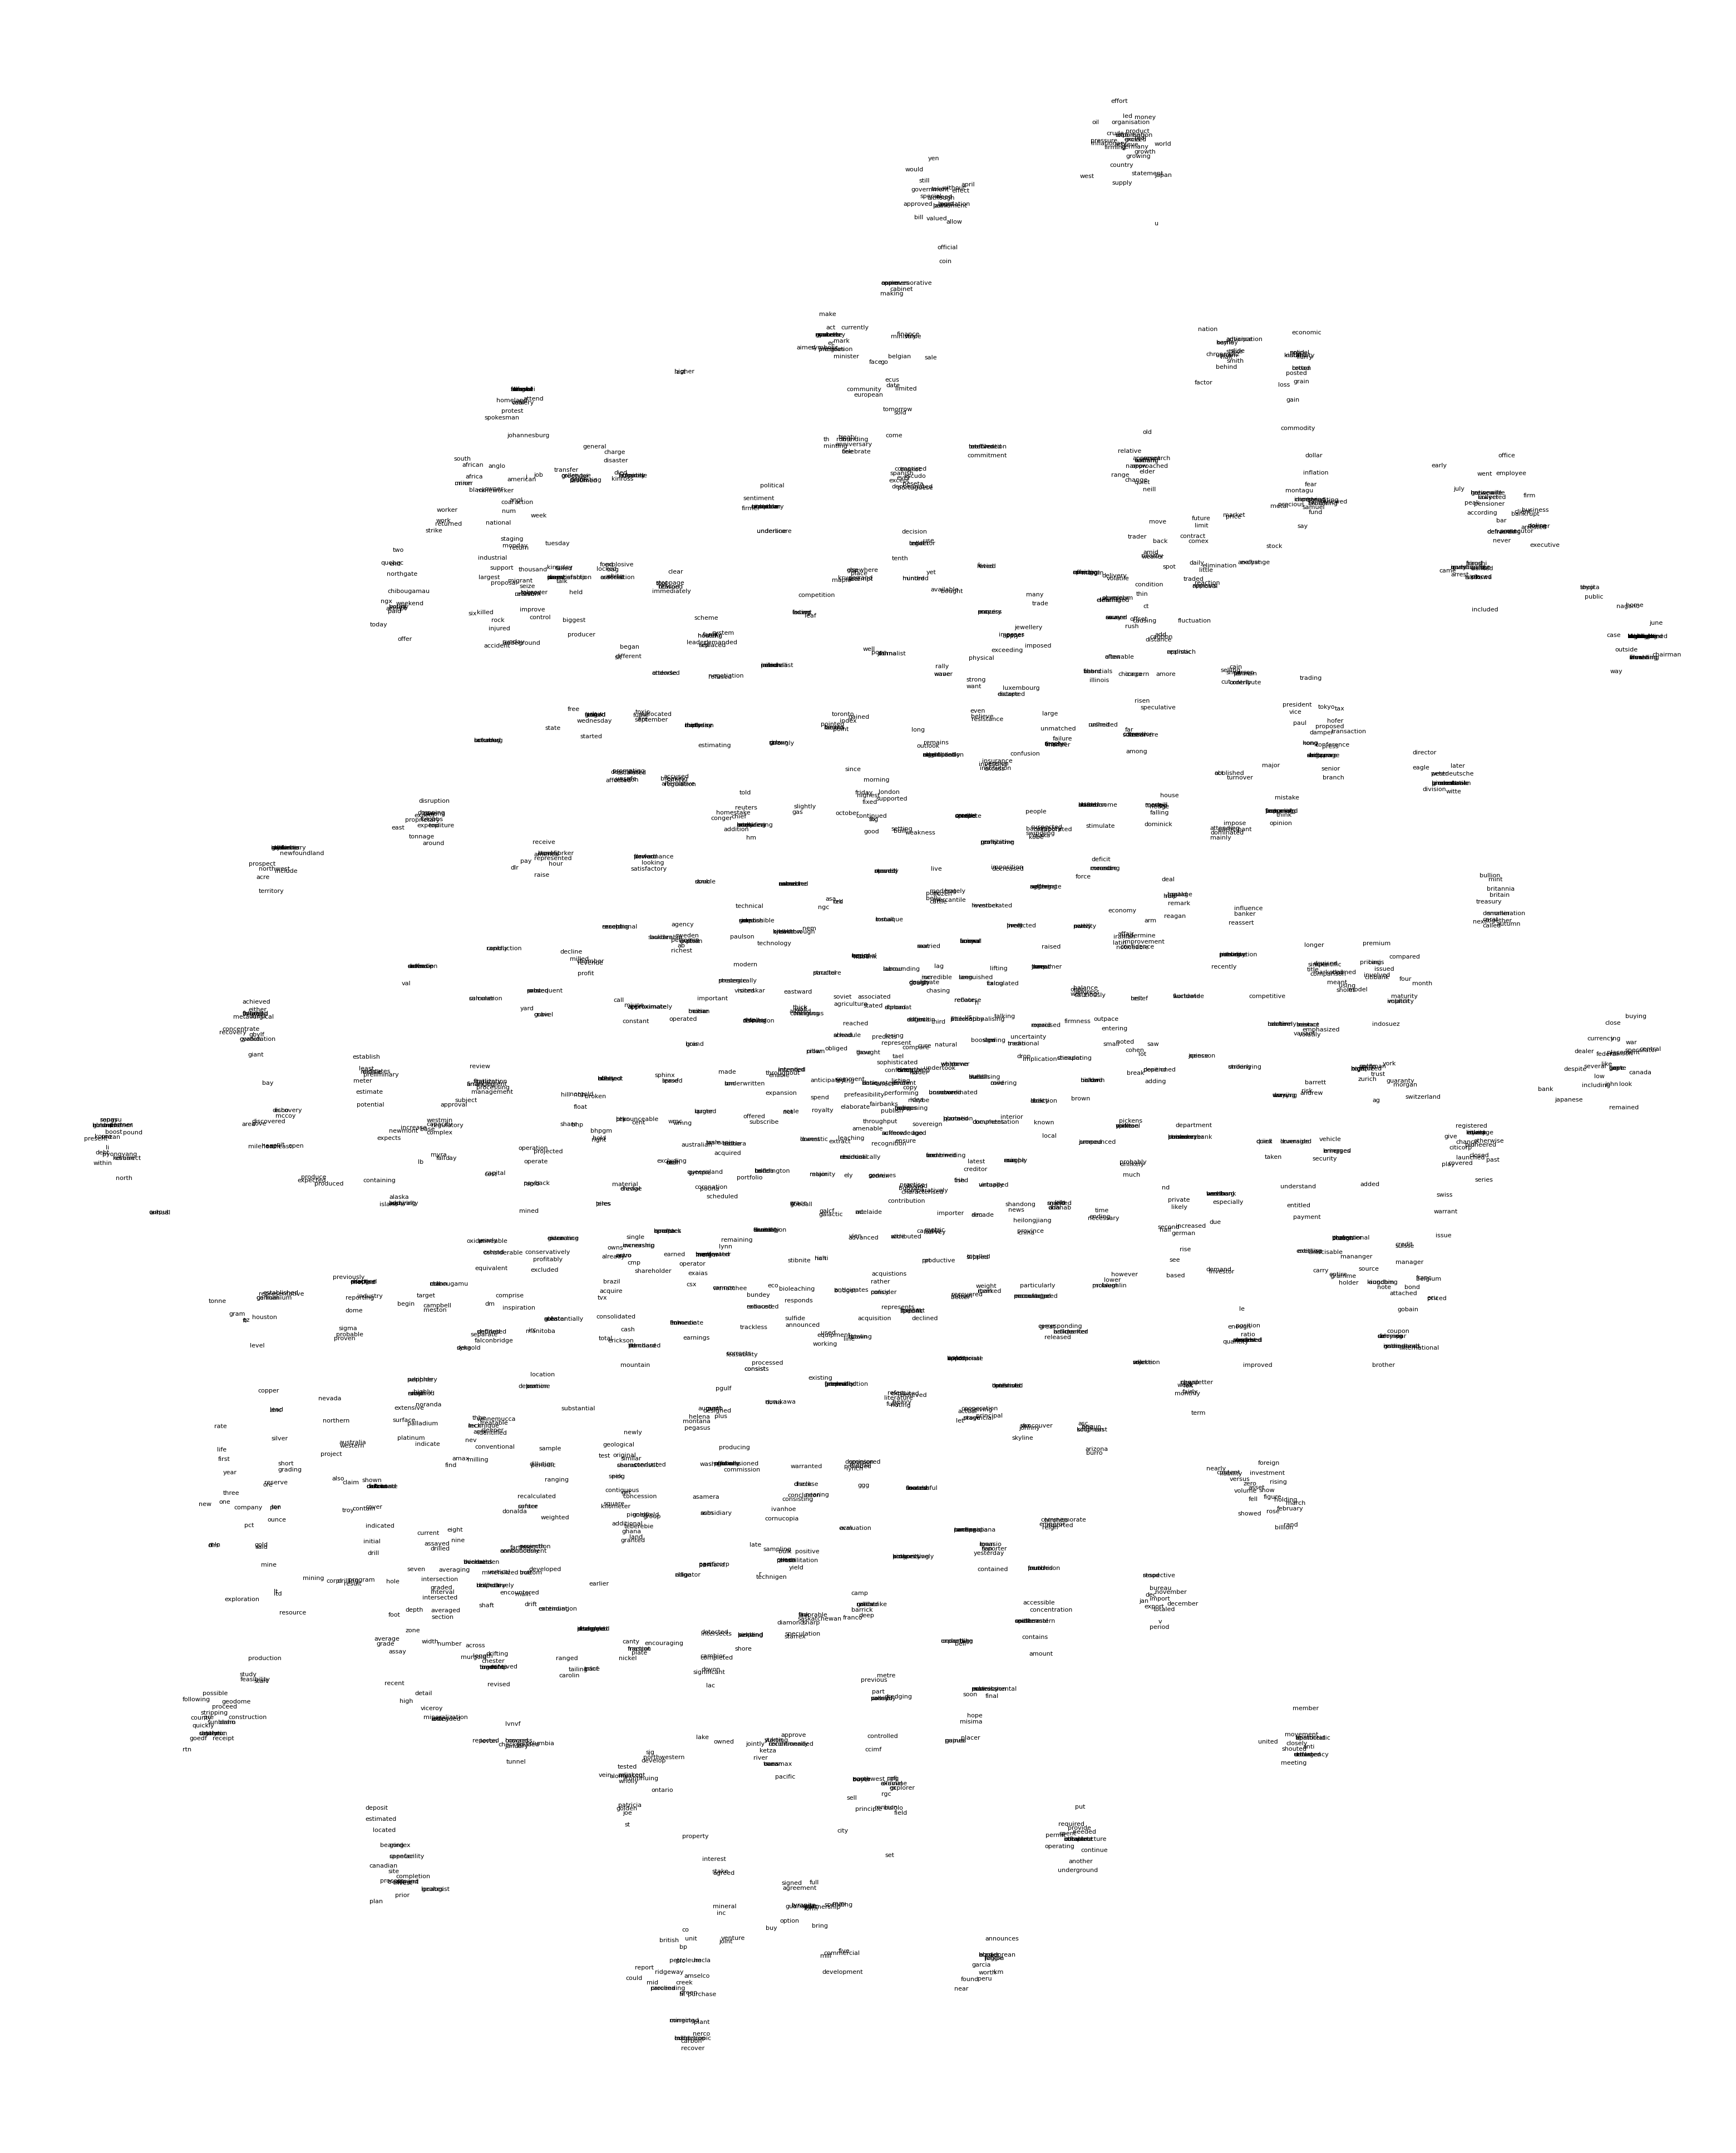

In [ ]:
tsne_viz(matrix_lsa, word_index, colors=None, output_filename=None, figsize=(40, 50), random_state=None)

## Part 3: Application to sentiment analysis

In this last part we will apply pre-computed word representation to perform **sentiment analysis**. We will use [Stanford Sentiment Treebank (SST)](http://nlp.stanford.edu/sentiment/), a widely-used dataset for evaluating supervised NLP models. This dataset contains sentences annotated with three different labels according to the sentiment they convey: positive, negative or neutral.

Here we have some examples of sentences with their labels that you can find in the dataset:

`[{'example_id': '04162-00001',
  'sentence': "One can only assume that the jury who bestowed star Hoffman 's brother Gordy with the Waldo Salt Screenwriting award at 2002 's Sundance Festival were honoring an attempt to do something different over actually pulling it off",
  'label': 'negative',
  'is_subtree': 0},
 {'example_id': '05626-00001',
  'sentence': "Comedy troupe Broken Lizard 's first movie is very funny but too concerned with giving us a plot .",
  'label': 'neutral',
  'is_subtree': 0},
 {'example_id': '02940-00001',
  'sentence': "Imagine O. Henry 's The Gift of the Magi relocated to the scuzzy underbelly of NYC 's drug scene .",
  'label': 'negative',
  'is_subtree': 0}]`
  

In [ ]:
DATA_HOME = 'data'
SST_HOME = os.path.join(DATA_HOME, 'sentiment')
train_df = sst.train_reader(SST_HOME)
train_df.sample(3).to_dict(orient="records")

[{'example_id': '00590-00001',
  'sentence': "Clint Eastwood 's Blood Work is a lot like a well-made PB & J sandwich : familiar , fairly uneventful and boasting no real surprises -- but still quite tasty and inviting all the same .",
  'label': 'positive',
  'is_subtree': 0},
 {'example_id': '04836-00001',
  'sentence': 'Just another combination of bad animation and mindless violence ... lacking the slightest bit of wit or charm .',
  'label': 'negative',
  'is_subtree': 0},
 {'example_id': '05449-00001',
  'sentence': "... Tara Reid plays a college journalist , but she looks like the six-time winner of the Miss Hawaiian Tropic Pageant , so I do n't know what she 's doing in here ...",
  'label': 'negative',
  'is_subtree': 0}]

For this we will use an already **pre-computed co-occurrence matrix**.

We will have to **implement** the function **`vsm_features`** that returns the feature representation of a text string. This function takes as input the text string and the matrix with of word representations and must get a single representation of the text string by computing the representation of all the words in the text string and aggegating them using some aggregation function (`sum`, `mean`, ...).

The process of classification of a text string is illustrated in the following figure:

<img src="fig/distreps-as-features.png" width=500 alt="distreps-as-features.png" />


### Computing features and training a classifier

In the next cell you have all the functions that are necessary to run the classification experiment on the sentiment dataset.

We have to implement the function **`fit_softmax_classifier`** that **trains a classifier** given a feature representation of the training set and the set of labels. This function uses `LogisticRegression` as a classifier, but any classifier could be used.

We have to **implement** the function **`vsm_features`** that get the aggregated representation of an input text string as explained before. The `vsm` parameter is a tuple that contains the vector space model, the matrix with the representation of all the words in the vocabulary and a dictionary with the mapping of all words to indices of the matrix. This function must compute the representation of all the words in the text string and aggregate them using the aggregation function specified in `aggr_func`.

In [ ]:
import nltk
from nltk import tokenize
from nltk.tokenize import word_tokenize

In [ ]:
def fit_softmax_classifier(X, y):
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='auto')
    mod.fit(X, y)
    return mod

def compute_features(text, aggr_func=np.sum):
    return vsm_features(text, vsm, aggr_func=aggr_func)

def vsm_features(text, vsm, aggr_func=np.sum):
    """Represent `text` as a combination of the vector of its words.

    Parameters
    ----------
    text : str

    vsm : tuple where the first element is a co-occurrence matrix and
    the second element is the dictionary that maps words to indices in
    the matrix

    aggr_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a
        fixed length, no matter what the size of the text is.

    Returns
    -------
    features: np.array, dimension `X.shape[1]`

    """

    matrix, word2ind = vsm
    words = word_tokenize(text)
    index_list = []
    for word in words:
      if word in word2ind:
        index_list.append(word2ind[word])

    vectors = matrix[index_list]
    features = aggr_func(vectors, axis=0)
    
    return features

### Creating the Vector Space Model

In the next cell we have the code to load pre-computed co-occurrence matrix and get the final vector space model that will be used for computing text features and perform the taks of sentiment classification.

First, we load the pre-computed `yelp20` matrix, convert it to a `numpy` array and create the dictionary mapping words to indices. Then, we normalize the matrix with PPMI and apply LSA to reduce dimensionality. Finally we create the final Vector Space Model that is needed for the function `vsm_features` as the tuple with the matrix and the dictionary.

In [ ]:
DATA_HOME = 'data'
VSMDATA_HOME = os.path.join(DATA_HOME, 'vsmdata')
SST_HOME = os.path.join(DATA_HOME, 'sentiment')

# Read pre-computed co-occurrence matrix
yelp20 = pd.read_csv(os.path.join(VSMDATA_HOME, 'yelp_window20-flat.csv.gz'), index_col=0)

# Convert co-occurrence matrix to numpy and create dictionary to map words to indices in the matrix
matrix = yelp20.to_numpy()
word_index = dict(zip(yelp20.index, range(len(yelp20.index))))

# Compute ppmi and lsa from original co-occurrence matrix
matrix_ppmi = compute_ppmi(matrix)
matrix_ppmi_lsa = lsa(matrix_ppmi, k=300)

# Create a tuple with the co-occurrence matrix and the word_index dictionary that will be used to compute word features
vsm = (matrix_ppmi_lsa, word_index)

Running SVD over 6000 words...
Done.


### Evaluation of the model

In the next cell we have the script to perform the classification experiment in the sentiment dataset. It loads the sentiment dataset, train a classifier using the function `fit_softmax_classifier` and the features computed using `vsm_features` and evaluates the classifier on the dev set of the sentiment dataset, reporting evaluation metrics.

**We will run this script** using the implementation of `vsm_features`. We will **try different configurations** of the vector space model and compare the results:  with and without PPMI normalization, different dimensionality of the embedding space after LSA, different values for the smoothing in PPMI , ...


In [ ]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)

# This code runs the experiment on the sentiment analysis dataset using `compute_features` to get a feature representation of a text string
# and `fit_softmax classifier` as a classification function


              precision    recall  f1-score   support

    negative      0.564     0.678     0.616       428
     neutral      0.312     0.044     0.077       229
    positive      0.578     0.723     0.643       444

    accuracy                          0.564      1101
   macro avg      0.485     0.481     0.445      1101
weighted avg      0.518     0.564     0.514      1101

CPU times: user 14.7 s, sys: 104 ms, total: 14.8 s
Wall time: 14.8 s


In [65]:
# Config without PPMI
matrix_lsa = lsa(matrix, k=300)

# Create a tuple with the co-occurrence matrix and the word_index dictionary that will be used to compute word features
vsm = (matrix_lsa, word_index)


Running SVD over 6000 words...
Done.


In [66]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)


              precision    recall  f1-score   support

    negative      0.567     0.612     0.589       428
     neutral      0.352     0.083     0.134       229
    positive      0.552     0.727     0.628       444

    accuracy                          0.549      1101
   macro avg      0.490     0.474     0.450      1101
weighted avg      0.516     0.549     0.510      1101

CPU times: user 1min 18s, sys: 192 ms, total: 1min 18s
Wall time: 1min 19s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


This config without ppmi seems to perform a little bit better at classifing neutrals but a little worse for the other 2 categories. Accuracy is also lower

In [67]:
#Config with 2-smoothing
matrix_ppmi = compute_ppmi(matrix,add_k_smoothing=2)
matrix_ppmi_lsa = lsa(matrix_ppmi, k=300)

# Create a tuple with the co-occurrence matrix and the word_index dictionary that will be used to compute word features
vsm = (matrix_ppmi_lsa, word_index)

Running SVD over 6000 words...
Done.


In [68]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)

              precision    recall  f1-score   support

    negative      0.562     0.668     0.610       428
     neutral      0.355     0.048     0.085       229
    positive      0.579     0.732     0.647       444

    accuracy                          0.565      1101
   macro avg      0.499     0.483     0.447      1101
weighted avg      0.526     0.565     0.516      1101

CPU times: user 14 s, sys: 103 ms, total: 14.1 s
Wall time: 14.5 s


This configuration with 2 smooting improves the macro avg and weighted avg of the model so it seems to permorm a little bit better

In [70]:
#Config with 4-smoothing
matrix_ppmi = compute_ppmi(matrix,add_k_smoothing=4)
matrix_ppmi_lsa = lsa(matrix_ppmi, k=300)

# Create a tuple with the co-occurrence matrix and the word_index dictionary that will be used to compute word features
vsm = (matrix_ppmi_lsa, word_index)

Running SVD over 6000 words...
Done.


In [71]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)

              precision    recall  f1-score   support

    negative      0.558     0.675     0.611       428
     neutral      0.357     0.044     0.078       229
    positive      0.584     0.730     0.649       444

    accuracy                          0.566      1101
   macro avg      0.500     0.483     0.446      1101
weighted avg      0.527     0.566     0.515      1101

CPU times: user 12.8 s, sys: 108 ms, total: 13 s
Wall time: 15.7 s


We can see improvements at classifing neutral and positive using 4-smoothing

In [72]:
#Setting the embedding dimension to 100
matrix_ppmi = compute_ppmi(matrix)
matrix_ppmi_lsa = lsa(matrix_ppmi, k=100)

vsm = (matrix_ppmi_lsa, word_index)

Running SVD over 6000 words...
Done.


In [73]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)

              precision    recall  f1-score   support

    negative      0.558     0.682     0.614       428
     neutral      0.750     0.013     0.026       229
    positive      0.570     0.736     0.642       444

    accuracy                          0.565      1101
   macro avg      0.626     0.477     0.427      1101
weighted avg      0.603     0.565     0.503      1101

CPU times: user 4.85 s, sys: 58 ms, total: 4.91 s
Wall time: 5.18 s


Setting the dimension 100 for the embedding space greatly improves precision for neutral

In [80]:
#Setting the embedding dimension to 400
matrix_ppmi = compute_ppmi(matrix)
matrix_ppmi_lsa = lsa(matrix_ppmi, k=400)

vsm = (matrix_ppmi_lsa, word_index)

Running SVD over 6000 words...
Done.


In [81]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)

              precision    recall  f1-score   support

    negative      0.573     0.661     0.614       428
     neutral      0.288     0.066     0.107       229
    positive      0.584     0.730     0.649       444

    accuracy                          0.565      1101
   macro avg      0.482     0.485     0.456      1101
weighted avg      0.518     0.565     0.522      1101

CPU times: user 18.8 s, sys: 120 ms, total: 18.9 s
Wall time: 18.9 s


The model with 400 embedding dimensions and no smoothing seems to classify the positive class a little bit better but to perform worse on neutral in terms of precision

In [97]:
#2 smoothing and 400 for embedding space
matrix_ppmi = compute_ppmi(matrix,add_k_smoothing=2)
matrix_ppmi_lsa = lsa(matrix_ppmi, k=400)

vsm = (matrix_ppmi_lsa, word_index)

Running SVD over 6000 words...
Done.


In [98]:
%%time
_ = sst.experiment(
    sst.train_reader(SST_HOME),
    compute_features,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    vectorize=False)

              precision    recall  f1-score   support

    negative      0.562     0.645     0.601       428
     neutral      0.255     0.057     0.093       229
    positive      0.578     0.727     0.644       444

    accuracy                          0.556      1101
   macro avg      0.465     0.476     0.446      1101
weighted avg      0.505     0.556     0.513      1101

CPU times: user 18.6 s, sys: 123 ms, total: 18.8 s
Wall time: 19.8 s


The 2 smoothing with 400 embedding dimensions seems to perform worse overall

# Conclusions:


*   The config without ppmi seems to perform a little bit better at classifing neutrals but a little worse for the other 2 categories. Accuracy is also lower
*   The configuration with 2 smooting improves the macro avg and weighted avg of the model so it seems to permorm a little bit better
*   We can see improvements at classifing neutral and positive using 4-smoothing
*   Setting the dimension 100 for the embedding space greatly improves precision for neutral
*   The model with 400 embedding dimensions and no smoothing seems to classify the positive class a little bit better but to perform worse on neutral in terms of precision
*   The 2 smoothing with 400 embedding dimensions seems to perform worse overall

